# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc
import time

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, LabelEncoder # OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, NMF

# Import libraries for Hypertuning
import optuna

import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LassoCV
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# !pip install sklego
from sklego.linear_model import LADRegression # Least Absolute Deviation Regression

from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

c:\Users\Emincan\miniconda3\envs\ml\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Data

In [2]:
filepath = r'C:/Users/Emincan/Desktop/Playground'

df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
original = pd.read_csv('CrabAgePrediction.csv')

df_train['is_generated'] = 1
df_test['is_generated'] = 1
original['is_generated'] = 0

target_col = 'Age'
num_cols = df_test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = df_test.select_dtypes(include=['object']).columns.tolist()

print(f"train shape :{df_train.shape}, ", f"test shape :{df_test.shape}")
print(f"original shape :{original.shape}")

train shape :(74051, 10),  test shape :(49368, 9)
original shape :(3893, 10)


In [3]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Blue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def check_data(data, title):
    cols = data.columns.to_list()
    display(set_frame_style(data[cols].head(),f'{title}: First 5 Rows Of Data'))
    display(set_frame_style(data[cols].describe(),f'{title}: Summary Statistics'))
    display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'{title}: Unique Value Counts In Each Column'))
    display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'{title}:Columns With Nan'))
    
check_data(df_train, 'Train data')
print('-'*100)
check_data(df_test, 'Test data')
print('-'*100)
check_data(original, 'Original data')

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
id,,,,,,,,,,
0,I,1.525000,1.175000,0.375000,28.973189,12.728926,6.647958,8.348928,9,1
1,I,1.100000,0.825000,0.275000,10.418441,4.521745,2.324659,3.401940,8,1
2,M,1.387500,1.112500,0.375000,24.777463,11.339800,5.556502,6.662133,9,1
3,F,1.700000,1.412500,0.500000,50.660556,20.354941,10.991839,14.996885,11,1
4,I,1.250000,1.012500,0.337500,23.289114,11.977664,4.507570,5.953395,8,1


,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806,1.000000
std,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189,0.000000
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000,1.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000,1.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000,1.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000,1.000000


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
Unique Value Count,3,144,122,65,3096,1766,967,1048,28,1


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
0,0,0,0,0,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,is_generated
id,,,,,,,,,
74051,I,1.050000,0.762500,0.275000,8.618248,3.657085,1.729319,2.721552,1
74052,I,1.162500,0.887500,0.275000,15.507176,7.030676,3.246018,3.968930,1
74053,F,1.287500,0.987500,0.325000,14.571643,5.556502,3.883882,4.819415,1
74054,F,1.550000,0.987500,0.387500,28.377849,13.380964,6.548735,7.030676,1
74055,I,1.112500,0.850000,0.262500,11.765042,5.528153,2.466407,3.331066,1


,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,is_generated
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876,1.000000
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650,0.000000
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930,1.000000
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627,1.000000
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063,1.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,1.000000


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,is_generated
Unique Value Count,3,140,122,57,2948,1692,938,987,1


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,is_generated
0,0,0,0,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
0,F,1.437500,1.175000,0.412500,24.635715,12.332033,5.584852,6.747181,9,0
1,M,0.887500,0.650000,0.212500,5.400580,2.296310,1.374951,1.559222,6,0
2,I,1.037500,0.775000,0.250000,7.952035,3.231843,1.601747,2.764076,6,0
3,F,1.175000,0.887500,0.250000,13.480187,4.748541,2.282135,5.244657,10,0
4,I,0.887500,0.662500,0.212500,6.903103,3.458639,1.488349,1.700970,6,0


,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791,0.000000
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967,0.000000
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000,0.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000,0.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000,0.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000,0.000000


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
Unique Value Count,3,134,111,51,2343,1482,867,907,28,1


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,is_generated
0,0,0,0,0,0,0,0,0,0,0


In [4]:
class CFG:
    """
    Class'ın amacı:
    - Feature engineering aşamasını aç-kapa formatına dönüştürerek bug azaltmak
    - Nihai çözümümde bazı featurelar olmasa dahi deneme yapılan feature kapsamını genişletmek/gösterebilmek.
    """
    target = 'Age'
    
    #Hangi dataların kullanılacağına karar verme
    encoder = True
    
    height_solver = True
    
    lenghtDiameterRatio_feature = False
    LenMinusHeight_feature = False
    WeightShellRatio_feature = False
    Volume_feature = False
    pseudoBMI_feature = True
    Weight_to_Viscera_feature = False
    Weight_to_ShuckedWeightRatio_feature = False
    LogDensity_feature = True
    
    object_to_category = True
    
    add_pca_features = True
    
    scaler = True
    
    #Feature türlerine karar verme
    ohe_cat_encoder = True
    label_cat_encoder = False
    
    height_solver_likeZero = True
    height_solver_knn = False
    height_solver_knnFeatures = False
    
    standart_scaler = True
    minmax_scaler = False
    
    
    #Feature parametreleri
    nasa_feature_columns =  ['T2M','T2MDEW','T2MWET','QV2M','RH2M','PRECTOTCORR','PS','WS10M','WD10M','WS50M']
    meteostat_feature_columns = ['dwpt','rhum','prcp','wdir','wspd','pres','coco']
    production_base_columns = ['fueloil','gasOil','blackCoal','lignite','geothermal','naturalGas','river','dammedHydro','lng','biomass','importCoal','asphaltiteCoal','wind','sun','importExport','wasteheat','total']
    consumption_base_columns = ['consumption']
    weather_lag_range = np.arange(0,51,5)
    rolling_range = np.arange(0,48,6)[1:]
    roll_types = ['mean','std','min','max']
    

# EDA

1) Train, Test and Original data histograms
2) Correlation of Features
3) Hierarchical Clustering
4) Pie and bar charts for categorical column features
5) Scatter Plot with Age Column by Sex
6) Distribution Plot by Sex
7) Boxplot by Sex
8) Violinplot by Sex
9) Scatter plots after dimensionality reduction with PCA by Sex

In [5]:
# def plot_histograms(df_train, df_test, original, target_col, n_cols=3):
#     n_rows = (len(df_train.columns) - 1) // n_cols + 1

#     fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
#     axes = axes.flatten()

#     for i, var_name in enumerate(df_train.columns.tolist()):
#         if var_name != 'is_generated':
#             ax = axes[i]
#             sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
#             if var_name != target_col:
#                 sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
#             sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
#             ax.set_title(f'{var_name} Distribution (Train vs Test)')
#             ax.legend()

#     plt.tight_layout()
#     plt.show()
        
# plot_histograms(df_train[num_cols], df_test[num_cols], original[num_cols], target_col, n_cols=4)

In [6]:
# def plot_heatmap(df, title):
#     # Create a mask for the diagonal elements
#     mask = np.zeros_like(df.astype(float).corr())
#     mask[np.triu_indices_from(mask)] = True

#     # Set the colormap and figure size
#     colormap = plt.cm.RdBu_r
#     plt.figure(figsize=(15, 15))

#     # Set the title and font properties
#     plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

#     # Plot the heatmap with the masked diagonal elements
#     sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
#                 square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
#                 mask=mask)

# plot_heatmap(df_train[num_cols+[target_col]], title='Train data')
# plot_heatmap(df_test[num_cols], title='Test data')
# plot_heatmap(original[num_cols+[target_col]], title='original')

In [7]:
# from scipy.cluster import hierarchy
# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.spatial.distance import squareform

# def hierarchical_clustering(data, title):
#     fig, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=120)
#     correlations = data.corr()
#     converted_corr = 1 - np.abs(correlations)
#     Z = linkage(squareform(converted_corr), 'complete')
    
#     dn = dendrogram(Z, labels=data.columns, ax=ax, above_threshold_color='#ff0000', orientation='right')
#     hierarchy.set_link_color_palette(None)
#     plt.grid(axis='x')
#     plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
#     plt.show()

# hierarchical_clustering(df_train[num_cols], title='Train data')
# hierarchical_clustering(df_test[num_cols], title='Test data')

In [8]:
# def plot_target_feature(df_train, target_col, figsize=(16,5), palette='colorblind', name='Train'):
#     df_train = df_train.fillna('Nan')

#     fig, ax = plt.subplots(1, 2, figsize=figsize)
#     ax = ax.flatten()

#     # Pie chart
#     pie_colors = sns.color_palette(palette, len(df_train[target_col].unique()))
#     ax[0].pie(
#         df_train[target_col].value_counts(),
#         shadow=True,
#         explode=[0.05] * len(df_train[target_col].unique()),
#         autopct='%1.f%%',
#         textprops={'size': 15, 'color': 'white'},
#         colors=pie_colors
#     )
#     ax[0].set_aspect('equal')  # Fix the aspect ratio to make the pie chart circular

#     # Bar plot
#     bar_colors = sns.color_palette(palette)
#     sns.countplot(
#         data=df_train,
#         y=target_col,
#         ax=ax[1],
#         palette=bar_colors
#     )
#     ax[1].set_xlabel('Count', fontsize=14)
#     ax[1].set_ylabel('')
#     ax[1].tick_params(labelsize=12)
#     ax[1].yaxis.set_tick_params(width=0)  # Remove tick lines for y-axis

#     fig.suptitle(f'{target_col} in {name} Dataset', fontsize=16, fontweight='bold')
#     plt.tight_layout()

#     # Show the plot
#     plt.show()
    
# plot_target_feature(df_train, 'Sex', figsize=(16,5), palette='colorblind', name='Train data')
# plot_target_feature(df_test, 'Sex', figsize=(16,5), palette='colorblind', name='Test data')

In [9]:
# def plot_scatter_with_fixed_col(df, fixed_col, hue=False, drop_cols=[], size=10, title=''):
#     sns.set_style('whitegrid')
    
#     if hue:
#         cols = df.columns.drop([hue, fixed_col] + drop_cols)
#     else:
#         cols = df.columns.drop([fixed_col] + drop_cols)
#     n_cols = 2
#     n_rows = (len(cols) - 1) // n_cols + 1
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(size, size/n_cols*n_rows), sharex=False, sharey=False)
#     fig.suptitle(f'{title} Set Scatter Plot with Target Column by {hue}', fontsize=24, fontweight='bold', y=1.01)

#     for i, col in enumerate(cols):
#         n_row = i // n_cols
#         n_col = i % n_cols
#         ax = axes[n_row, n_col]

#         ax.set_xlabel(f'{col}', fontsize=14)
#         ax.set_ylabel(f'{fixed_col}', fontsize=14)

#         # Plot the scatterplot
#         if hue:
#             sns.scatterplot(data=df, x=col, y=fixed_col, hue=hue, ax=ax,
#                             s=80, edgecolor='gray', alpha=0.35, palette='bright')
#             ax.legend(title=hue, title_fontsize=12, fontsize=12) # loc='upper right'
#         else:
#             sns.scatterplot(data=df, x=col, y=fixed_col, ax=ax,
#                             s=80, edgecolor='gray', alpha=0.35)

#         ax.tick_params(axis='both', which='major', labelsize=10)
#         ax.set_title(f'{col}', fontsize=18)
    
#     plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
#     plt.show()
    
# plot_scatter_with_fixed_col(df_train, fixed_col=target_col, hue='Sex', drop_cols=['is_generated'], size=16, title='Train data')
# plot_scatter_with_fixed_col(original, fixed_col=target_col, hue='Sex', drop_cols=['is_generated'], size=16, title='Original data')

In [10]:
# def plot_distribution(df, hue, title='', drop_cols=[]):
#     sns.set_style('whitegrid')

#     cols = df.columns.drop([hue] + drop_cols)
#     n_cols = 2
#     n_rows = (len(cols) - 1) // n_cols + 1

#     fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

#     for i, var_name in enumerate(cols):
#         row = i // n_cols
#         col = i % n_cols

#         ax = axes[row, col]
#         sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
#         ax.set_title(f'{var_name} Distribution')

#     fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
#     plt.tight_layout()
#     plt.show()
    
# plot_distribution(df_train, hue='Sex', title='Train data', drop_cols=['is_generated'])
# plot_distribution(df_test, hue='Sex', title='Test data', drop_cols=['is_generated'])
# plot_distribution(original, hue='Sex', title='Original data', drop_cols=['is_generated'])

In [11]:
# def plot_boxplot(df, hue, title='', drop_cols=[], n_cols=3):
#     sns.set_style('whitegrid')

#     cols = df.columns.drop([hue] + drop_cols)
#     n_rows = (len(cols) - 1) // n_cols + 1

#     fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

#     for i, var_name in enumerate(cols):
#         row = i // n_cols
#         col = i % n_cols

#         ax = axes[row, col]
#         sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
#                     meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
#         ax.set_title(f'{var_name} by {hue}')
#         ax.set_xlabel('')

#     fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=16)
#     plt.tight_layout()
#     plt.show()
    
# plot_boxplot(df_train, hue='Sex', title='Train data', drop_cols=['is_generated'], n_cols=2)
# plot_boxplot(original, hue='Sex', title='Original data', drop_cols=['is_generated'], n_cols=2)
# plot_boxplot(df_test, hue='Sex', title='Test data', drop_cols=['is_generated'], n_cols=2)

In [12]:
# def plot_violinplot(df, hue, title='', drop_cols=[], n_cols=2):
#     sns.set_style('whitegrid')

#     cols = df.columns.drop([hue] + drop_cols)
#     n_rows = (len(cols) - 1) // n_cols + 1

#     fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

#     for i, var_name in enumerate(cols):
#         row = i // n_cols
#         col = i % n_cols

#         ax = axes[row, col]
#         sns.violinplot(data=df, x=hue, y=var_name, ax=ax, inner='quartile')
#         ax.set_title(f'{var_name} Distribution')

#     fig.suptitle(f'{title} Violin Plot by {hue}', fontweight='bold', fontsize=16)
#     plt.tight_layout()
#     plt.show()
    
# plot_violinplot(df_train, hue='Sex', title='Train data', drop_cols=['is_generated'], n_cols=2)

In [13]:
# class Decomp:
#     def __init__(self, n_components, method="pca", scaler_method='standard'):
#         self.n_components = n_components
#         self.method = method
#         self.scaler_method = scaler_method
        
#     def dimension_reduction(self, df):
            
#         X_reduced = self.dimension_method(df)
#         df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
#         return df_comp
    
#     def dimension_method(self, df):
        
#         X = self.scaler(df)
#         if self.method == "pca":
#             pca = PCA(n_components=self.n_components, random_state=0)
#             X_reduced = pca.fit_transform(X)
#             self.comp = pca
#         elif self.method == "nmf":
#             nmf = NMF(n_components=self.n_components, random_state=0)
#             X_reduced = nmf.fit_transform(X)
#         else:
#             raise ValueError(f"Invalid method name: {method}")
        
#         return X_reduced
    
#     def scaler(self, df):
        
#         _df = df.copy()
            
#         if self.scaler_method == "standard":
#             return StandardScaler().fit_transform(_df)
#         elif self.scaler_method == "minmax":
#             return MinMaxScaler().fit_transform(_df)
#         elif self.scaler_method == None:
#             return _df.values
#         else:
#             raise ValueError(f"Invalid scaler_method name")
        
#     def get_columns(self):
#         return [f'{self.method.upper()}_{_}' for _ in range(self.n_components)]
    
#     def get_explained_variance_ratio(self):
#         return np.sum(self.comp.explained_variance_ratio_)
    
#     def transform(self, df):
#         X = self.scaler(df)
#         X_reduced = self.comp.transform(X)
#         df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        
#         return df_comp
    
#     def decomp_plot(self, tmp, label, hue='genre'):
#         plt.figure(figsize = (16, 9))
#         sns.scatterplot(x = f"{label}_0", y = f"{label}_1", data=tmp, hue=hue, alpha=0.7, s=100, palette='muted');

#         plt.title(f'{label} on {hue}', fontsize = 20)
#         plt.xticks(fontsize = 14)
#         plt.yticks(fontsize = 10);
#         plt.xlabel(f"{label} Component 1", fontsize = 15)
#         plt.ylabel(f"{label} Component 2", fontsize = 15)
    
    
# data = df_train.drop(['Sex', 'Age'], axis=1)
# for method in ['pca', 'nmf']:
#     decomp = Decomp(n_components=2, method=method, scaler_method='minmax')
#     decomp_feature = decomp.dimension_reduction(data)
#     decomp_feature = pd.concat([df_train[['Sex']], decomp_feature], axis=1)
#     decomp.decomp_plot(decomp_feature, method.upper(), 'Sex')

In [14]:
# def plot_scatter_with_fixed_col(df, fixed_col, hue=False, drop_cols=[], size=10, title=''):
#     sns.set_style('whitegrid')
    
#     if hue:
#         cols = df.columns.drop([hue, fixed_col] + drop_cols)
#     else:
#         cols = df.columns.drop([fixed_col] + drop_cols)
#     n_cols = 2
#     n_rows = 1
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(size, size/n_cols*n_rows), sharex=False, sharey=False)
#     fig.suptitle(f'{title} Set Scatter Plot with Target Column by {hue}', fontsize=24, fontweight='bold', y=1.01)

#     for i, col in enumerate(cols):
#         n_row = i // n_cols
#         n_col = i % n_cols
#         ax = axes[n_col]

#         ax.set_xlabel(f'{col}', fontsize=14)
#         ax.set_ylabel(f'{fixed_col}', fontsize=14)

#         # Plot the scatterplot
#         if hue:
#             sns.scatterplot(data=df, x=col, y=fixed_col, hue=hue, ax=ax,
#                             s=80, edgecolor='gray', alpha=0.35, palette='bright')
#             ax.legend(title=hue, title_fontsize=12, fontsize=12) # loc='upper right'
#         else:
#             sns.scatterplot(data=df, x=col, y=fixed_col, ax=ax,
#                             s=80, edgecolor='gray', alpha=0.35)

#         ax.tick_params(axis='both', which='major', labelsize=10)
#         ax.set_title(f'{col}', fontsize=18)
    
#     plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
#     plt.show()
    

# decomp = Decomp(n_components=2, method='pca', scaler_method='standard')
# decomp_feature = decomp.dimension_reduction(data)
# decomp_feature = pd.concat([df_train[['Sex', 'Age']], decomp_feature], axis=1)    
# plot_scatter_with_fixed_col(decomp_feature, fixed_col=target_col, hue='Sex', drop_cols=[], size=16, title='PCA data')

# Feature Engineering

* cat_encoder() : Perform label encoding and one-hot encoding. OneHotEnconder was done with the Sex feature this time.
* create_features() : Create new features.
* add_pca_features() : Add PCA results as features. Since this data set is highly correlated, it may be a good idea to perform a PCA.


Note: Not all of the above feature engineering is adapted in this kernel. Please take it as an idea.

In [15]:
def cat_encoder(X_train, X_test, cat_cols, encode='label'):
    
    if encode == 'label':
        ## Label Encoder
        encoder = OrdinalEncoder(cols=cat_cols, handle_missing='ignore')
        train_encoder = encoder.fit_transform(X_train[cat_cols]).astype(int)
        test_encoder = encoder.transform(X_test[cat_cols]).astype(int)
        X_train[cat_cols] = train_encoder[cat_cols]
        X_test[cat_cols] = test_encoder[cat_cols]
        encoder_cols = cat_cols
    
    else:
        ## OneHot Encoder
        encoder = OneHotEncoder(cols=cat_cols)
        train_encoder = encoder.fit_transform(X_train[cat_cols]).astype(int)
        test_encoder = encoder.transform(X_test[cat_cols]).astype(int)
        X_train = pd.concat([X_train, train_encoder], axis=1)
        X_test = pd.concat([X_test, test_encoder], axis=1)
        X_train.drop(cat_cols, axis=1, inplace=True)
        X_test.drop(cat_cols, axis=1, inplace=True)
        encoder_cols = list(train_encoder.columns)
        
    return X_train, X_test, encoder_cols

def height_solver(df, how = 'likeZero' , feats = None):
    if how == 'likeZero':
        df['Height'].replace(0, 0.0001 , inplace = True)
        return df
    
    elif how == 'knnImputer':
        df['Height'].replace(0, np.nan, inplace=True)

        imputer = KNNImputer(n_neighbors=5)
        df['Height'] = imputer.fit_transform(train[['Height']])
        
    elif how == 'knnImputerFeats' :
        if feats is None :
            print('Lütfen knnImputer uygulanacak featureları seçin.')
        else :
            imputer_features = feats
            imputer = KNNImputer(n_neighbors=5)

            # Use the KNNImputer for train
            train_imputed = imputer.fit_transform(df[imputer_features])
            df[imputer_features] = train_imputed
    

def create_lenghtDiameterRatio_feature(df):
    
    # Calculate the Length-to-Diameter Ratio
    df["Length_to_Diameter_Ratio"] = df["Length"] / df["Diameter"]    
    return df

def create_LenMinusHeight_feature(df):
    df["Length_Minus_Height"] = df["Length"] - df["Height"]
    return df

def create_WeightShellRatio_feature(df):
    # Calculate the Weight-to-Shell Weight Ratio
    df["Weight_to_Shell_Weight_Ratio"] = np.clip(df['Weight'] / df['Shell Weight'],0,1000)
    return df

def create_Volume_feature(df):
    df["Volume"] = df["Length"] * df["Height"] * df["Diameter"]
    return df

def create_pseudoBMI_feature(df):
    df['PseudoBMI'] = (df['Weight'] / (df['Height']**2)).clip(0, 4000)
    return df

def create_Weight_to_Viscera_feature(df):
    df['Weight_to_Viscera'] = np.clip(df['Weight'] / df['Viscera Weight'], 0, 1000)
    return df

def create_Weight_to_ShuckedWeightRatio_feature(df):
    df['WgtDivShckWgt']  = np.clip(df['Weight'] / df['Shucked Weight'],0,1000)
    return df


# def create_LogDensity_feature(df):
#     train['LogDensity'] = np.log(df['Weight'] / df['Volume'])
#     test['LogDensity'] = np.log(test['Weight'] / test['Volume'])
#     original['LogDensity'] = np.log(original['Weight'] / original['Volume'])


def object_to_category(df , cat_cols):
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df




def add_pca_features(X_train, X_test):    
    
    # Select the columns for PCA
    pca_features = X_train.select_dtypes(include=['float64']).columns.tolist()
    n_components = 4 # len(pca_features)

    # Create the pipeline
    pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))
    
    # Perform PCA
    pipeline.fit(X_train[pca_features])

    # Create column names for PCA features
    pca_columns = [f'PCA_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test

In [16]:
# Concatenate train and original dataframes, and prepare train and test sets
train = pd.concat([df_train, original])
test = df_test.copy()

X_train = train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = train[f'{target_col}'].reset_index(drop=True)
X_test = test.reset_index(drop=True)

num_cols = X_train.select_dtypes(include=['float64' , 'float32' , 'int64' , 'int32']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Category Encoders
if CFG.encoder:
    if CFG.ohe_cat_encoder:
        X_train, X_test, cat_cols = cat_encoder(X_train, X_test, cat_cols, encode='ohe')
    elif CFG.label_cat_encoder:
        X_train, X_test, cat_cols = cat_encoder(X_train, X_test, cat_cols, encode='label')
        
    

# Create Features
if CFG.height_solver:
    if CFG.height_solver_likeZero:
        X_train = height_solver(X_train , how = 'likeZero')
        X_test = height_solver(X_test , how = 'likeZero')
    elif CFG.height_solver_knn:
        X_train = height_solver(X_train , how = 'knnImputer')
        X_test = height_solver(X_test , how = 'knnImputer')     
    elif CFG.height_solver_knnFeatures:
        X_train = height_solver(X_train , how = 'knnImputerFeats')
        X_test = height_solver(X_test , how = 'knnImputerFeats')               
        
    
if CFG.lenghtDiameterRatio_feature:
    X_train = create_lenghtDiameterRatio_feature(X_train)
    X_test = create_lenghtDiameterRatio_feature(X_test)
    
if CFG.LenMinusHeight_feature:
    X_train = create_LenMinusHeight_feature(X_train)
    X_test = create_LenMinusHeight_feature(X_test)

if CFG.WeightShellRatio_feature:
    X_train = create_WeightShellRatio_feature(X_train)
    X_test = create_WeightShellRatio_feature(X_test)
    
if CFG.Volume_feature:
    X_train = create_Volume_feature(X_train)
    X_test = create_Volume_feature(X_test)   
    
if CFG.lenghtDiameterRatio_feature:
    X_train = create_lenghtDiameterRatio_feature(X_train)
    X_test = create_lenghtDiameterRatio_feature(X_test)
    
if CFG.pseudoBMI_feature:
    X_train = create_pseudoBMI_feature(X_train)
    X_test = create_pseudoBMI_feature(X_test)
    
if CFG.Weight_to_Viscera_feature:
    X_train = create_Weight_to_Viscera_feature(X_train)
    X_test = create_Weight_to_Viscera_feature(X_test)
    
if CFG.Weight_to_ShuckedWeightRatio_feature:
    X_train = create_Weight_to_ShuckedWeightRatio_feature(X_train)
    X_test = create_Weight_to_ShuckedWeightRatio_feature(X_test)
    
if CFG.add_pca_features:
    X_train, X_test = add_pca_features(X_train, X_test)
    
if CFG.scaler:
    if CFG.standart_scaler:
        sc = StandardScaler() # MinMaxScaler or StandardScaler
        X_train[num_cols] = sc.fit_transform(X_train[num_cols])
        X_test[num_cols] = sc.transform(X_test[num_cols])
    elif CFG.minmax_scaler:
        sc = MinMaxScaler() # MinMaxScaler or StandardScaler
        X_train[num_cols] = sc.fit_transform(X_train[num_cols])
        X_test[num_cols] = sc.transform(X_test[num_cols])       
        
    
# X_train = height_solver(X_train)
# X_test = height_solver(X_test)

# X_train = create_lenghtDiameterRatio_feature(X_train)
# X_test = create_lenghtDiameterRatio_feature(X_test)

# X_train = create_LenMinusHeight_feature(X_train)
# X_test = create_LenMinusHeight_feature(X_test)

# X_train = create_WeightShellRatio_feature(X_train)
# X_test = create_WeightShellRatio_feature(X_test)

# X_train = create_Volume_feature(X_train)
# X_test = create_Volume_feature(X_test)


# X_train = create_lenghtDiameterRatio_feature(X_train)
# X_test = create_lenghtDiameterRatio_feature(X_test)

# X_train = create_pseudoBMI_feature(X_train)
# X_test = create_pseudoBMI_feature(X_test)

# X_train = create_Weight_to_Viscera_feature(X_train)
# X_test = create_Weight_to_Viscera_feature(X_test)

# X_train = create_Weight_to_ShuckedWeightRatio_feature(X_train)
# X_test = create_Weight_to_ShuckedWeightRatio_feature(X_test)

# X_train, X_test = add_pca_features(X_train, X_test)

# # StandardScaler
# sc = StandardScaler() # MinMaxScaler or StandardScaler
# X_train[num_cols] = sc.fit_transform(X_train[num_cols])
# X_test[num_cols] = sc.transform(X_test[num_cols])

# Drop_col
# drop_cols = ['is_generated', 'Sex_2', 'Length']
drop_cols = ['is_generated']
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# del train, test, df_train, df_test

X_train.head(5)

X_train shape :(77944, 15) , y_train shape :(77944,)
X_test shape :(49368, 15)


,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_1,Sex_2,Sex_3,PseudoBMI,PCA_0,PCA_1,PCA_2,PCA_3
0,0.720685,0.633266,0.289535,0.438832,0.463414,0.564473,0.450014,1,0,0,206.031566,1.381389,0.211215,0.077572,-0.230493
1,-0.752950,-0.837648,-0.788955,-1.020677,-0.988508,-0.974553,-0.922953,1,0,0,137.764512,-2.409979,-0.127868,0.216286,-0.053189
2,0.243921,0.370603,0.289535,0.108798,0.217665,0.175932,-0.018132,0,1,0,176.195292,0.521283,-0.061083,0.186573,-0.169276
3,1.327476,1.631386,1.637648,2.144752,1.812523,2.110826,2.295062,0,0,1,202.642226,4.901469,-0.280426,-0.625128,0.481954
4,-0.232843,-0.049658,-0.114899,-0.008275,0.330509,-0.197471,-0.214832,1,0,0,204.458617,-0.142171,0.365354,-0.168984,-0.144487


# Data Splitting

In [17]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5, cat_df=pd.DataFrame(), test_size=0.5):
        self.n_splits = n_splits
        self.kfold = kfold
        self.cat_df = cat_df
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, self.cat_df):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        elif self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

# Define Model

LightGBM, CatBoost Xgboost and HistGradientBoosting hyper parameters are determined by optuna.

In [18]:
class Regressor:
    def __init__(self, n_estimators=1000, device="gpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
                
        xgb_params = {
                         'objective'          : 'reg:pseudohubererror',
                         'eval_metric'        : 'mae',
                         'random_state'       : self.random_state,
                         'tree_method'        : "gpu_hist" if self.device else "hist",
                         'colsample_bytree'   : 0.8,
                         'learning_rate'      : 0.010,
                         'max_depth'          : 9,
                         'n_estimators'       : 6000,                         
                         'reg_alpha'          : 1.25,
                         'reg_lambda'         : 1e-05,
                         'min_child_weight'   : 40,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb1_params = {
            'device'            : "gpu" if self.device else "cpu",
            'objective'         : 'regression_l1',
            'metric'            : 'mean_absolute_error',
            'boosting_type'     : 'gbdt',
            'random_state'      : self.random_state,
            'feature_fraction'  : 0.70,
            'learning_rate'     : 0.018,
            'max_depth'         : 12,
            'n_estimators'      : 12_000,
            'num_leaves'        : 80,                    
            'reg_alpha'         : 1.25,
            'reg_lambda'        : 3.5,
            'verbose'           : -1,
        }
        
        cat1_params = {
                    'task_type'           : "CPU",
                    'loss_function'       : 'MAE',
                    'eval_metric'         : 'MAE',
                    'bagging_temperature' : 2.5,
                    'colsample_bylevel'   : 0.8,
                    'iterations'          : 15_000,
                    'learning_rate'       : 0.067,
                    'od_wait'             : 40,
                    'max_depth'           : 6,
                    'l2_leaf_reg'         : 1.575,
                    'min_data_in_leaf'    : 28,
                    'random_strength'     : 0.55, 
                    'max_bin'             : 256,
                    # 'cat_features' : cat_cols
                           }
        
        hist_params = {
            'loss': 'absolute_error',
            'l2_regularization': 0.0104104133357932,
            'early_stopping': True,
            'learning_rate': 0.00627298859709192,
            'max_iter': 15000,
            'n_iter_no_change': 300,
            'max_depth': 16,
            'max_bins': 255,
            'min_samples_leaf': 54,
            'max_leaf_nodes':57,
            'random_state': self.random_state,
            #'categorical_features': []
        }
        gbd_params = {
            'loss': 'absolute_error',
            'n_estimators': 2000,
            'max_depth': 12,
            'learning_rate': 0.01,
            'min_samples_split': 10,
            'min_samples_leaf': 20,
            'random_state': self.random_state,
        }
        
        models = {
#             "lad": LADRegression(),
            "xgb": xgb.XGBRegressor(**xgb_params),
            "lgb": lgb.LGBMRegressor(**lgb1_params),
            "cat": CatBoostRegressor(**cat1_params),
            'hgb': HistGradientBoostingRegressor(**hist_params),
            # "SVR_rbf": SVR(kernel="rbf", gamma="auto"),
#             "SVR_linear": SVR(kernel="linear", gamma="auto"),
#             "Ridge": RidgeCV(),
#             "Lasso": LassoCV(),
#             "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),            
            # "RandomForestRegressor": RandomForestRegressor(n_estimators=500, random_state=self.random_state, n_jobs=-1),
#             "SGDRegressor": SGDRegressor(max_iter=2000, early_stopping=True, n_iter_no_change=100, random_state=self.random_state),
            # "MLPRegressor": MLPRegressor(max_iter=500, early_stopping=True, n_iter_no_change=10, random_state=self.random_state),
#             "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=self.random_state),
#             "PLSRegression": PLSRegression(n_components=10, max_iter=1000),
            #"PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=self.random_state),
#             "TheilSenRegressor": TheilSenRegressor(max_iter=1000, random_state=self.random_state, n_jobs=-1),
            "GradientBoostingRegressor": GradientBoostingRegressor(**gbd_params),
#             "ARDRegression": ARDRegression(n_iter=1000),
#             "HuberRegressor": HuberRegressor(max_iter=2000)
        }
        
        return models

In [19]:
# class Regressor:
#     def __init__(self, n_estimators=1000, device="gpu", random_state=0):
#         self.n_estimators = n_estimators
#         self.device = device
#         self.random_state = random_state
#         self.models = self._define_model()
#         self.models_name = list(self._define_model().keys())
#         self.len_models = len(self.models)
        
#     def _define_model(self):
                
#         xgb_params = {
#             'n_estimators': self.n_estimators,
#             'learning_rate': 0.00482382842096919,
#             'booster': 'gbtree',
#             'lambda': 0.000235366507474591,
#             'alpha': 0.0000115977765684837,
#             'subsample': 0.35955930593108,
#             'colsample_bytree': 0.898528184386095,
#             'max_depth': 9,
#             'min_child_weight': 8,
#             'eta': 0.0000784943239744148,
#             'gamma': 1.6661346939401E-07,
#             'grow_policy': 'lossguide',
#             'n_jobs': -1,
#             'objective': 'reg:squarederror', # reg:pseudohubererror
#             'eval_metric': 'mae',
#             'verbosity': 0,
#             'random_state': self.random_state,
#         }
#         if self.device == 'gpu':
#             xgb_params['tree_method'] = 'gpu_hist'
#             xgb_params['predictor'] = 'gpu_predictor'
        
#         lgb1_params = {
#             'n_estimators': self.n_estimators,
#             'learning_rate': 0.00659605502010782,
#             "reg_alpha": 0.0134568843414818,
#             "reg_lambda": 2.38367559632979E-06,
#             "num_leaves": 117,
#             "colsample_bytree": 0.850706320762174,
#             'subsample': 0.691827302225948,
#             'subsample_freq': 4,
#             'min_child_samples': 33,
#             'objective': 'regression_l2',
#             'metric': 'mae',
#             'boosting_type': 'gbdt',
#             'device': self.device,
#             'random_state': self.random_state
#         }
#         cat1_params = {
#             'task_type' : 'CPU',
#             'iterations': self.n_estimators,
#             'depth': 7,
#             'learning_rate': 0.00454306521731278,
#             'l2_leaf_reg': 0.113774158297261,
#             'random_strength': 0.0179641854849499,
#             'od_type': 'IncToDec',
#             'od_wait': 50,
#             'bootstrap_type': 'Bayesian',
#             'grow_policy': 'Lossguide',
#             'bagging_temperature': 1.39240858193441,
#             'eval_metric': 'MAE',
#             'loss_function': 'MAE',
#             'task_type': self.device.upper(),
#             'verbose': False,
#             'allow_writing_files': False,
#             'random_state': self.random_state,
#             # 'cat_features' : cat_cols
#         }
#         hist_params = {
#             'loss': 'absolute_error',
#             'l2_regularization': 0.0104104133357932,
#             'early_stopping': True,
#             'learning_rate': 0.00627298859709192,
#             'max_iter': self.n_estimators,
#             'n_iter_no_change': 200,
#             'max_depth': 16,
#             'max_bins': 255,
#             'min_samples_leaf': 54,
#             'max_leaf_nodes':57,
#             'random_state': self.random_state,
#             #'categorical_features': []
#         }
#         gbd_params = {
#             'loss': 'absolute_error',
#             'n_estimators': 800,
#             'max_depth': 10,
#             'learning_rate': 0.01,
#             'min_samples_split': 10,
#             'min_samples_leaf': 20,
#             'random_state': self.random_state,
#         }
        
#         models = {
# #             "lad": LADRegression(),
#             "xgb": xgb.XGBRegressor(**xgb_params),
#             "lgb": lgb.LGBMRegressor(**lgb1_params),
#             "cat": CatBoostRegressor(**cat1_params),
#             'hgb': HistGradientBoostingRegressor(**hist_params),
#             # "SVR_rbf": SVR(kernel="rbf", gamma="auto"),
# #             "SVR_linear": SVR(kernel="linear", gamma="auto"),
# #             "Ridge": RidgeCV(),
# #             "Lasso": LassoCV(),
# #             "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),            
#             # "RandomForestRegressor": RandomForestRegressor(n_estimators=500, random_state=self.random_state, n_jobs=-1),
# #             "SGDRegressor": SGDRegressor(max_iter=2000, early_stopping=True, n_iter_no_change=100, random_state=self.random_state),
#             # "MLPRegressor": MLPRegressor(max_iter=500, early_stopping=True, n_iter_no_change=10, random_state=self.random_state),
# #             "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=self.random_state),
# #             "PLSRegression": PLSRegression(n_components=10, max_iter=1000),
#             #"PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=self.random_state),
# #             "TheilSenRegressor": TheilSenRegressor(max_iter=1000, random_state=self.random_state, n_jobs=-1),
#             "GradientBoostingRegressor": GradientBoostingRegressor(**gbd_params),
# #             "ARDRegression": ARDRegression(n_iter=1000),
# #             "HuberRegressor": HuberRegressor(max_iter=2000)
#         }
        
#         return models

# Feature Selection (RFE-CV)

RFECV is a technique for automated feature selection that combines recursive feature elimination and cross-validation to identify the optimal subset of features for a given machine learning task.

Note: RFE-CV takes a lot of time. Here n_estimators are reduced to save time. When originally used, it is recommended to run with the actual hyperparameters.

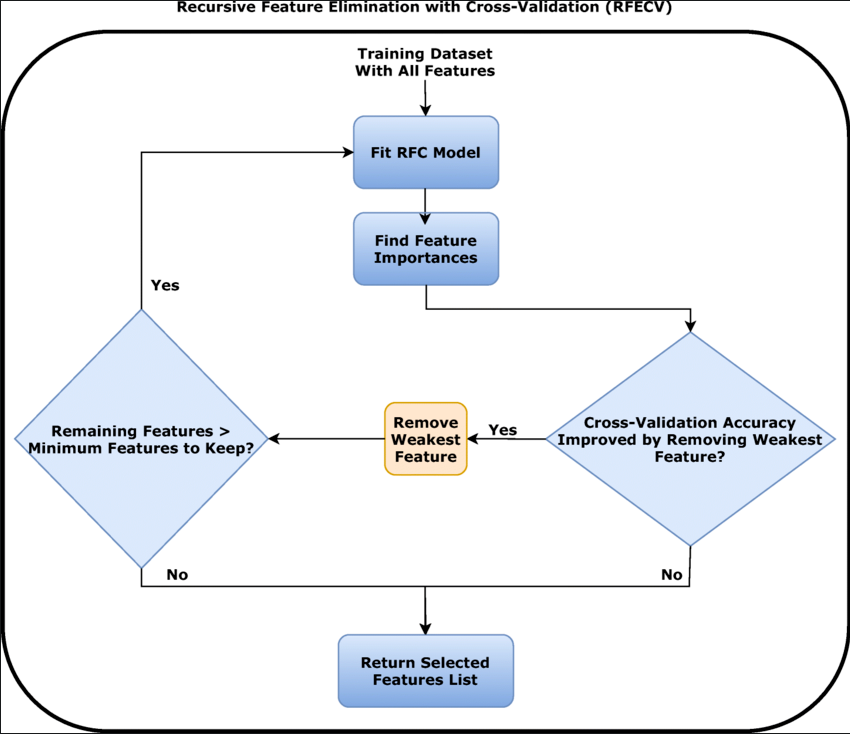

Reference: Feature fusion based machine learning pipeline to improve breast cancer prediction, 81, p.37627–37655 (2022) https://doi.org/10.1007/s11042-022-13498-4

In [20]:
splitter = Splitter(kfold=False)
for X_train_, X_val, y_train_, y_val in splitter.split_data(X_train, y_train, random_state_list=[34]):
    print('Data set by train_test_split')

Data set by train_test_split


In [21]:
X_train_.isna().sum()

Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Sex_1             0
Sex_2             0
Sex_3             0
PseudoBMI         0
PCA_0             0
PCA_1             0
PCA_2             0
PCA_3             0
dtype: int64

In [22]:
%%time

n_estimators = 500
scoring = 'neg_mean_absolute_error'
min_features_to_select = 6

regressor = Regressor(n_estimators, device='cpu', random_state= 34)
models = regressor.models

models_name = [_ for _ in regressor.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)]
trained_models = dict(zip(models_name, ['' for _ in range(regressor.len_models)]))
unnecessary_features = dict(zip(models_name, [[] for _ in range(regressor.len_models)]))
for name, model in models.items():
    if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
        elimination = RFECV(
            model, 
            step=1,
            min_features_to_select=min_features_to_select,
            cv=2,
            scoring=scoring, 
            n_jobs=-1)
        elimination.fit(X_train_, y_train_)
        unnecessary_feature = list(X_train.columns[~elimination.get_support()])
        idx = np.argmax(elimination.cv_results_['mean_test_score'])
        mean_score = elimination.cv_results_['mean_test_score'][idx]
        std_score = elimination.cv_results_['std_test_score'][idx]
        print(f'{blu}{name}{res} {red} Best Mean{res} MAE {red}{mean_score:.5f} ± {std_score:.5f}{res} | N_STEP {idx}')
        print(f"unnecessary_feature: {unnecessary_feature}")
        print(f'{"-" * 60}')
        
        trained_models[f'{name}'] = deepcopy(elimination)
        unnecessary_features[f'{name}'].extend(unnecessary_feature)
        
unnecessary_features = np.concatenate([_ for _ in unnecessary_features.values()])
features = np.unique(unnecessary_features, return_counts=True)[0]
counts = np.unique(unnecessary_features, return_counts=True)[1]
drop_features = list(features[counts >= 2])
print("Features recommended to be removed:", drop_features)

xgb  Best Mean MAE -1.40489 ± 0.00252 | N_STEP 2
unnecessary_feature: ['Diameter', 'Viscera Weight', 'Sex_2', 'Sex_3', 'PseudoBMI', 'PCA_1', 'PCA_2']
------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
lgb  Best Mean MAE -1.40974 ± 0.00215 | N_STEP 9
unnecessary_feature: []
------------------------------------------------------------


CatBoostError: 'data' is numpy array of floating point numerical type, it means no categorical features, but 'cat_features' parameter specifies nonzero number of categorical features

In [ ]:
# X_train.drop(['Length_to_Diameter_Ratio', 'PCA_1', 'PCA_2'] , axis = 1 , inplace = True)
# X_test.drop(['Length_to_Diameter_Ratio', 'PCA_1', 'PCA_2'] , axis = 1 , inplace = True)

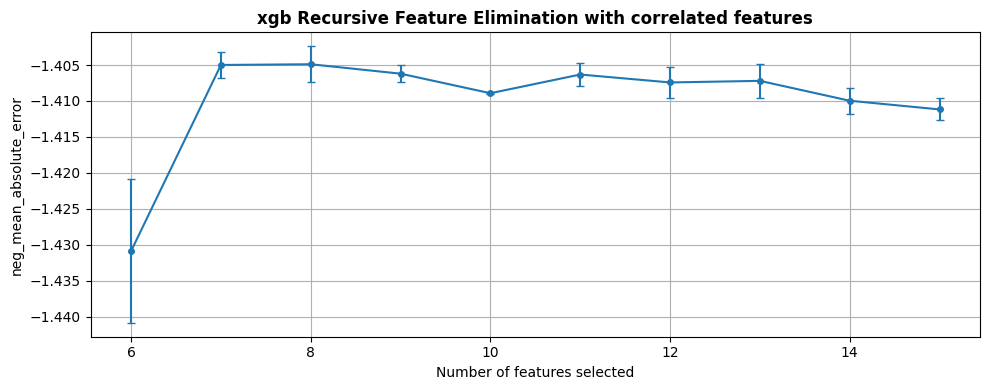

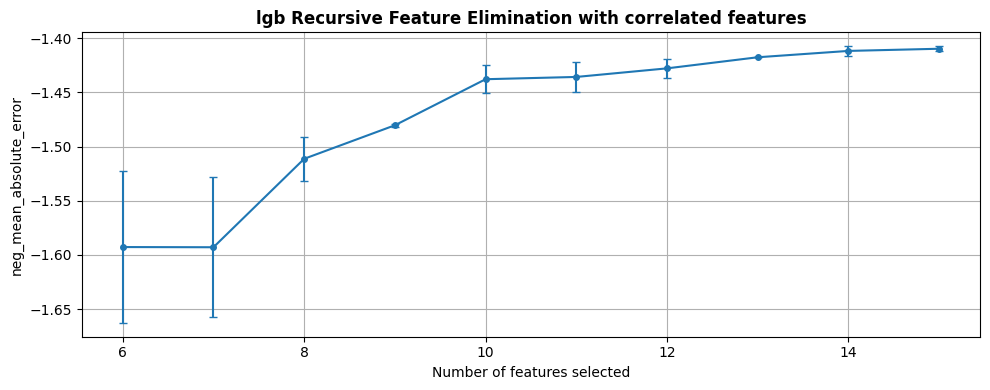

AttributeError: 'str' object has no attribute 'cv_results_'

In [23]:
def plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name):
    n_scores = len(elimination.cv_results_["mean_test_score"])
    plt.figure(figsize=(10, 4))
    plt.xlabel("Number of features selected")
    plt.ylabel(f"{scoring}")

    # Plot the mean test scores with error bars
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        elimination.cv_results_["mean_test_score"],
        yerr=elimination.cv_results_["std_test_score"],
        fmt='o-',
        capsize=3,
        markersize=4,
    )

    plt.title(f"{name} Recursive Feature Elimination with correlated features", fontweight='bold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
for name, elimination in trained_models.items():
    plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name)

# Weighted Ensemble by Optuna on Training

A weighted average is performed during training;

The weights were determined for each model using the predictions for the train data created in the out of fold with Optuna's CMAsampler. (Here it is defined by OptunaWeights)

This is an extension of the averaging method. All models are assigned different weights defining the importance of each model for prediction.

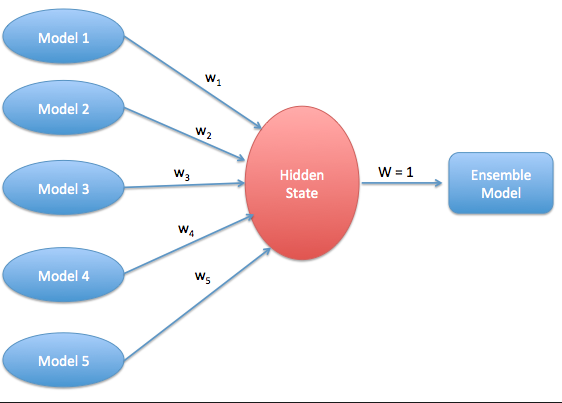

# Optimizer(--> Optimize MAE)

In [24]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=100):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = mean_absolute_error(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [25]:
# Settings
kfold = True
n_splits = 5
n_reapts = 1 # 1
random_state = 34
n_estimators = 99999 # 99999
early_stopping_rounds = 400
n_trials = 3000 # 3000
verbose = False
device = 'gpu'

# Fix seed
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)

# To calculate runtime
def sec_to_minsec(t):
    min_ = int(t / 60)
    sec = int(t - min_*60)
    return min_, sec

In [26]:
X_train

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_1,Sex_2,Sex_3,PseudoBMI,PCA_0,PCA_1,PCA_2,PCA_3
0,0.720685,0.633266,0.289535,0.438832,0.463414,0.564473,0.450014,1,0,0,206.031566,1.381389,0.211215,0.077572,-0.230493
1,-0.752950,-0.837648,-0.788955,-1.020677,-0.988508,-0.974553,-0.922953,1,0,0,137.764512,-2.409979,-0.127868,0.216286,-0.053189
2,0.243921,0.370603,0.289535,0.108798,0.217665,0.175932,-0.018132,0,1,0,176.195292,0.521283,-0.061083,0.186573,-0.169276
3,1.327476,1.631386,1.637648,2.144752,1.812523,2.110826,2.295062,0,0,1,202.642226,4.901469,-0.280426,-0.625128,0.481954
4,-0.232843,-0.049658,-0.114899,-0.008275,0.330509,-0.197471,-0.214832,1,0,0,204.458617,-0.142171,0.365354,-0.168984,-0.144487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77939,0.503974,0.475668,-0.249710,0.112143,0.272833,0.281897,-0.096812,0,0,1,234.982128,0.577019,0.679366,0.072450,-0.568452
77940,0.807369,0.790864,0.963592,0.870330,0.944880,0.751174,0.847349,0,0,1,180.029739,2.246168,-0.241626,-0.000855,0.051094
77941,-2.399953,-2.361094,-2.002257,-1.681860,-1.653033,-1.615394,-1.690084,1,0,0,76.224928,-5.161481,-0.421745,-0.812964,0.282272
77942,-0.882976,-1.047778,-0.923767,-1.026252,-0.991016,-0.969507,-1.040973,1,0,0,150.168780,-2.615754,0.046812,0.050744,-0.035170


In [27]:
%%time

# Initialize an array for storing test predictions
regressor = Regressor(n_estimators, device, random_state)
test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0], n_reapts))
ensemble_score, ensemble_score_ = [], []
weights = []
trained_models = dict(zip([_ for _ in regressor.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)], [[] for _ in range(regressor.len_models)]))
score_dict = dict(zip(regressor.models_name, [[] for _ in range(regressor.len_models)]))

splitter = Splitter(kfold=kfold, n_splits=n_splits)
for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of regressor models
    regressor = Regressor(n_estimators, device, random_state_list[m])
    models = regressor.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        best_iteration = None
        start_time = time.time()
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            early_stopping_rounds_ = int(early_stopping_rounds*1.5) if name != 'cat' else early_stopping_rounds
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds_, verbose=verbose)
            best_iteration = model.best_iteration if name == 'xgb' else model.best_iteration_
        else:
            model.fit(X_train_, y_train_)
        end_time = time.time()
        min_, sec = sec_to_minsec(end_time - start_time)
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict(X_test).reshape(-1)
        y_val_pred = model.predict(X_val).reshape(-1)
        
        score = mean_absolute_error(y_val, y_val_pred)
        score_dict[name].append(score)
        print(f'{blu}{name}{res} [FOLD-{n} SEED-{random_state_list[m]}] MAE {blu}{score:.5f}{res} | Best iteration {blu}{best_iteration}{res} | {min_}min {sec}s')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state_list[m], n_trials=n_trials)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = mean_absolute_error(y_val, y_val_pred)
    print(f'{red}>>> Ensemble{res} [FOLD-{n} SEED-{random_state_list[m]}] MAE {red}{score:.5f}{res}')
    print(f'{"-" * 60}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index, m] += optweights.predict(oof_preds)
    
    gc.collect()

xgb [FOLD-0 SEED-8666] MAE 1.36219 | Best iteration 1314 | 0min 8s
lgb [FOLD-0 SEED-8666] MAE 1.35108 | Best iteration 902 | 0min 29s
cat [FOLD-0 SEED-8666] MAE 1.35521 | Best iteration 1563 | 0min 9s
hgb [FOLD-0 SEED-8666] MAE 1.35682 | Best iteration None | 0min 59s
GradientBoostingRegressor [FOLD-0 SEED-8666] MAE 1.36781 | Best iteration None | 17min 34s
>>> Ensemble [FOLD-0 SEED-8666] MAE 1.34952
------------------------------------------------------------
xgb [FOLD-1 SEED-8666] MAE 1.37732 | Best iteration 1162 | 0min 8s
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
lgb [FOLD-1 SEED-8666] MAE 1.36425 | Best iteration 1092 | 0min 28s
cat [FOLD-1 SEED-8666] MAE 1.36888 | Best iteration 2549 | 0min 13s
hgb [FOLD-1 SEED-8666] MAE 1.37216 | Best iteration None | 0min 42s


# Mean Scores for each Model

In [ ]:
def plot_score_from_dict(score_dict, title='MAE', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

print('--- Mean MAE Scores---')    
for name, score in score_dict.items():
    mean_score = np.mean(score)
    std_score = np.std(score)
    print(f'{name}: {red}{mean_score:.5f} ± {std_score:.5f}{res}')
plot_score_from_dict(score_dict, title=f'MAE (n_splits:{n_splits})')

In [ ]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'{red}Mean{res} Optuna Ensemble MAE {red}{mean_score:.5f} ± {std_score:.5f}{res}')

print('')
# Print the mean and standard deviation of the ensemble weights for each model
print('--- Optuna Weights---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {blu}{mean_weight:.5f} ± {std_weight:.5f}{res}')

# weight_dict = dict(zip(list(score_dict.keys()), np.array(weights).T.tolist()))
# plot_score_from_dict(weight_dict, title='Model Weights', ascending=False)
normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
plot_score_from_dict(weight_dict, title='Optuna Weights (Normalize 0 to 1)', ascending=False)

In [ ]:
def visualize_importance(models, feature_cols, title, top=9):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(12, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='skyblue', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
for name, models in trained_models.items():
    if name in list(trained_models.keys()):
        visualize_importance(models, list(X_train.columns), name)

# Make Submission

mattop_post_process takes a list of predictions and returns an array of target values. 

It calculates the absolute difference between each prediction and all target values, and then selects the target value with the smallest difference for each prediction.
Reference: https://www.kaggle.com/competitions/playground-series-s3e14/discussion/407327

In [ ]:
unique_targets = np.unique(y_train)
def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

In [ ]:
def oof_result(oof_preds, y_train, title):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(oof_preds, kde=True, alpha=0.5, label='oof_preds')
    sns.histplot(y_train.values, kde=True, alpha=0.5, label='y_train')
    plt.title('Histogram of OOF Predictions and Train Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_train.values, y=oof_preds, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('OOF Predicted Values')
    plt.title('Actual vs. OOF Predicted Values')
    plt.suptitle(f'{title}', fontweight='bold', fontsize=16)

    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', alpha=0.5)
    plt.show()
    
oof_result(np.mean(oof_predss, axis=1), y_train, title='')
oof_result(mattop_post_process(np.mean(oof_predss, axis=1)), y_train, title='After Mattop post process')

In [ ]:
subs = pd.DataFrame()

sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
sub[f'{target_col}'] = test_predss
sub.to_csv('submission.csv', index=False)

subs = pd.concat([subs, sub], axis=1)

sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
sub[f'{target_col}'] = mattop_post_process(test_predss)
sub.to_csv('submission_mattop_nocat_xgb_lgb_hgb_pca_dropped.csv', index=False)

pd.merge(subs, sub, on='id', suffixes=("", "_mattop"))

In [ ]:
# Done.

# Final Compare

In [ ]:
def pearson_compare(df1 , df2 , feature = 'Age'):
    from scipy.stats import pearsonr
    df1_values = df1[feature].values
    df2_values = df2[feature].values
    
    # Pearson korelasyon katsayısı hesaplama
    correlation, _ = pearsonr(df1_values, df2_values)
    
    print(f"Pearson Korelasyon Katsayısı:", correlation)
    
  
def jaccard_compare(df1 , df2 , feature = 'Age'):
    from sklearn.metrics import jaccard_score
    df1_values = df1[feature].values
    df2_values = df2[feature].values
    
    # Jaccard benzerlik katsayısı hesaplama
    jaccard_similarity = jaccard_score(df1_values, df2_values , average='weighted')
    
    print(f"Jaccard Benzerlik Katsayısı:", jaccard_similarity)  


In [ ]:
df1 = pd.read_csv(r'C:\Users\Emincan\Desktop\Playground\submission_mattop_cat_xgb_lgb_hgb_pca_dropped.csv')
df2 = pd.read_csv(r'C:\Users\Emincan\Desktop\Playground\preds\submitted\submission_mattop_cat_xgb_lgb_hgb_2_1.3446.csv')

print(pearson_compare(df1,df2))
print(jaccard_compare(df1,df2))

In [ ]:
df1

In [ ]:
df2

In [ ]:
# Done.